# Time Series Anomaly Detection

In [1]:
from __future__ import division
import itertools
from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

## Acquire

In [2]:
colnames=['date', 'time', 'page_viewed','user_id','cohort_id','ip']
df = pd.read_csv('anonymized-curriculum-access.txt',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0,1,2,3,4,5]
)

## Prepare

In [3]:
df = df.fillna(0)

In [4]:
df.cohort_id = df.cohort_id.astype('int')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719459 entries, 0 to 719458
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   date         719459 non-null  object
 1   time         719459 non-null  object
 2   page_viewed  719459 non-null  object
 3   user_id      719459 non-null  int64 
 4   cohort_id    719459 non-null  int64 
 5   ip           719459 non-null  object
dtypes: int64(2), object(4)
memory usage: 32.9+ MB


In [6]:
df.head()

,date,time,page_viewed,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22,97.105.19.61


### Change datetime

In [7]:
df['datetime'] = df.date + " " + df.time

In [8]:
df['datetime'] = pd.to_datetime(df.datetime)

In [9]:
df['year'] = df.datetime.dt.year

In [10]:
df['month'] = df.datetime.dt.month

In [11]:
df['day'] = df.datetime.dt.day

In [12]:
df['hour'] = df.datetime.dt.hour

In [13]:
df['weekday'] = df.datetime.dt.day_name()

In [14]:
df = df.set_index('datetime')

In [15]:
df.drop(columns=['date', 'time'], inplace = True)

In [16]:
df.head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday
datetime,,,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,2018,1,26,9,Friday
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,2018,1,26,9,Friday
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,2018,1,26,9,Friday
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,2018,1,26,9,Friday
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,2018,1,26,9,Friday


In [29]:
df.cohort_id.value_counts()

28    60315
0     44840
33    40168
29    37548
53    36047
24    35624
57    32447
56    31670
22    30328
51    29688
58    28354
32    28333
23    28329
26    27637
52    27518
25    25427
31    25253
34    25181
59    22425
27    20447
55    20411
61    11774
14     9495
1      8884
62     8718
21     7444
17     4925
13     2733
18     2005
8      1712
19     1165
16      743
15      691
7       495
12      302
11      208
2        93
6        72
9         5
4         4
5         1
Name: cohort_id, dtype: int64

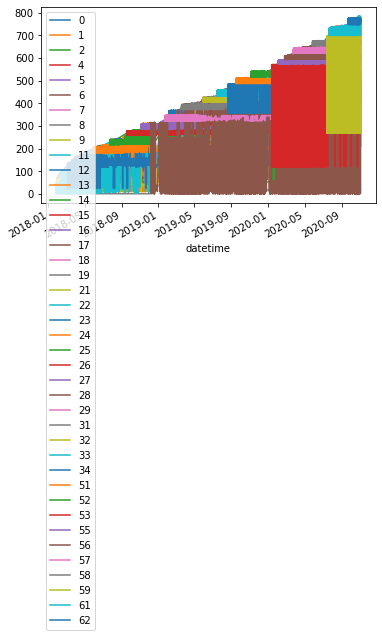

In [26]:
df.groupby('cohort_id').user_id.plot()
plt.legend()
plt.show()

Based on the color on the graph, my best guess is that we are in cohort 9,21,32 or 59.
we can further explore and see what we find in terms of dates and size of class.

### Explore

In [33]:
df[df.cohort_id == 9].head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday
datetime,,,,,,,,,
2018-03-22 19:01:49,/,152,9,207.68.209.17,2018,3,22,19,Thursday
2018-03-22 19:01:54,content/html-css,152,9,207.68.209.17,2018,3,22,19,Thursday
2018-03-22 19:01:54,content/html-css/gitbook/images/favicon.ico,152,9,207.68.209.17,2018,3,22,19,Thursday
2018-03-22 19:02:47,content/html-css,152,9,207.68.209.17,2018,3,22,19,Thursday
2018-03-22 19:02:52,content/html-css/introduction.html,152,9,207.68.209.17,2018,3,22,19,Thursday


In [34]:
df[df.cohort_id == 21].head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday
datetime,,,,,,,,,
2018-01-26 10:08:22,mkdocs/search_index.json,10,21,97.105.19.61,2018,1,26,10,Friday
2018-01-26 10:08:34,git/merge-conflict-demo,10,21,97.105.19.61,2018,1,26,10,Friday
2018-01-26 10:08:45,mkdocs/search_index.json,10,21,97.105.19.61,2018,1,26,10,Friday
2018-01-26 10:08:55,git/working-in-teams,10,21,97.105.19.61,2018,1,26,10,Friday
2018-01-26 10:18:22,/,10,21,97.105.19.61,2018,1,26,10,Friday


In [35]:
df[df.cohort_id == 32].head()

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday
datetime,,,,,,,,,
2019-05-29 09:48:59,/,407,32,97.105.19.58,2019,5,29,9,Wednesday
2019-05-29 09:56:08,/,408,32,97.105.19.58,2019,5,29,9,Wednesday
2019-05-29 10:01:23,/,409,32,97.105.19.58,2019,5,29,10,Wednesday
2019-05-29 10:01:28,/,410,32,97.105.19.58,2019,5,29,10,Wednesday
2019-05-29 10:01:31,html-css,409,32,97.105.19.58,2019,5,29,10,Wednesday


In [36]:
df[df.cohort_id == 59]

,page_viewed,user_id,cohort_id,ip,year,month,day,hour,weekday
datetime,,,,,,,,,
2020-07-13 14:34:44,/,678,59,76.201.20.193,2020,7,13,14,Monday
2020-07-13 14:37:22,/,679,59,24.28.146.155,2020,7,13,14,Monday
2020-07-13 14:38:28,/,680,59,136.50.56.155,2020,7,13,14,Monday
2020-07-13 14:39:21,13-advanced-topics/1-tidy-data,679,59,24.28.146.155,2020,7,13,14,Monday
2020-07-13 14:39:36,1-fundamentals/1.1-intro-to-data-science,679,59,24.28.146.155,2020,7,13,14,Monday
...,...,...,...,...,...,...,...,...,...
2020-11-02 15:47:59,appendix/useful_libraries,698,59,24.28.150.196,2020,11,2,15,Monday
2020-11-02 15:48:03,appendix/ds-environment-setup,698,59,24.28.150.196,2020,11,2,15,Monday
2020-11-02 15:48:14,appendix/interview_questions_students,698,59,24.28.150.196,2020,11,2,15,Monday


After some exploration into the dates, I have identified cohort 59 as Darden.

In [37]:
darden = df[df.cohort_id == 59]

In [40]:
darden.user_id.nunique()

28

<AxesSubplot:xlabel='user_id'>

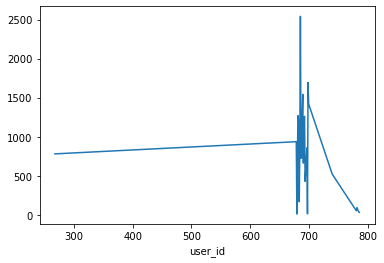

In [59]:
darden.groupby('user_id').page_viewed.count().plot()

user_id
268     781
678     937
679      11
680     847
681    1270
682    1184
683     168
684     853
685    2542
686     725
687     732
688    1248
689    1544
690     663
691    1222
692    1261
693     429
694     567
695     702
696     858
697      13
698    1695
699    1420
739     522
780      52
781      94
783      54
785      31
Name: page_viewed, dtype: int64